# Preparation

## Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim import lr_scheduler

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from transformers import AdamW, get_linear_schedule_with_warmup


from fetchData import fetchdata, cv_events
import __MLP
# from __MLP import getSamplers, convert_df_to_unsqueezed_tensor, train_sequential, clf_report
import random

pd.set_option('display.max_columns', None)

In [3]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## Data

In [ ]:
# pheme_AVGw2v = pd.read_csv('./data/_PHEME_text_AVGw2v.csv').drop(['token'],axis=1)
# pheme_sparse = pd.read_csv('./data/_PHEME_sparse.csv')
pheme_event = pd.read_csv('./data/_PHEME_text.csv')['Event']
# pheme_bert = fetchdata('pheme','bert')
# pheme_thread =  fetchdata('pheme','thread')
# pheme_thread_log = pd.read_csv('./data/_PHEME_thread_log.csv')
# pheme_thread_avg = pd.read_csv('./data/_PHEME_thread_avg.csv')

# ext_AVGw2v = pd.read_csv('./data/_PHEMEext_text_AVGw2v.csv').drop(['token'],axis=1)
ext_sparse = pd.read_csv('./data/_PHEMEext_sparse.csv')
ext_event = pd.read_csv('./data/_PHEMEext_text.csv').Event
# ext_bert = fetchdata('ext','bert')
# ext_bert = pd.read_csv('./data/_PHEMEext_Bert_simple.csv')
# ext_bert_bracket = pd.read_csv('./data/_PHEMEext_Bert_brackets.csv')

# ext_thread = fetchdata('ext','thread')
# ext_thread_log = pd.read_csv('./data/_PHEMEext_thread_log.csv')
# ext_thread_avg= pd.read_csv('./data/_PHEMEext_thread_avg.csv')

# rhi = pd.read_csv('./data/_RHI_text_AVGw2v.csv').drop(['token'],axis=1)
# rhi_y = pd.read_csv('./data/_RHI_target.csv')
# rhi_bert = fetchdata('rhi','bert')

pheme_bert_simple = pd.read_csv('./data/_PHEME_Bert_simple.csv')
pheme_bert_bracket = pd.read_csv('./data/_PHEME_Bert_brackets.csv')
pheme_bert_twttknr = pd.read_csv('./data/_PHEME_Bert_twttknzr.csv')
pheme_bert_lemma = pd.read_csv('./data/_PHEME_Bert_lemma.csv')
pheme_bert_twttknr_lemma = pd.read_csv('./data/_PHEME_Bert_simple_twtknzr_lemma.csv')
pheme_y = pd.read_csv('./data/_PHEME_target.csv').target
ext_bert_simple = pd.read_csv('./data/_PHEMEext_Bert_simple.csv')
ext_bert_bracket = pd.read_csv('./data/_PHEMEext_Bert_brackets.csv')
ext_bert_twttknr = pd.read_csv('./data/_PHEMEext_Bert_twttknzr.csv')
ext_bert_lemma = pd.read_csv('./data/_PHEMEext_Bert_lemma.csv')
ext_bert_twttknr_lemma = pd.read_csv('./data/_PHEMEext_Bert_simple_twtknzr_lemma.csv')
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target


def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
set_seed()

In [5]:
pd.concat([pheme_event,ext_event]).value_counts()

charliehebdo         2079
sydneysiege          1221
ferguson             1143
ottawashooting        890
germanwings-crash     469
putinmissing          238
prince-toronto        233
ebola-essien           14
Name: Event, dtype: int64

In [6]:
# cv = Preprocessing.cv_events(pd.concat([pheme_sparse, pheme_y, pheme_event],axis=1))
# X = cv[3][1].drop(['target', 'Event'],axis=1)
# y = cv[3][1].target
# val_X = cv[3][0].drop(['target', 'Event'],axis=1)
# val_y = cv[3][0].target

In [7]:
class BERT_net(nn.Module):
    def __init__(self):
        super(BERT_net, self).__init__() # 1*20
        self.fc1 = nn.Linear(768, 50, bias=True) # 420
        self.fc2 = nn.Linear(50, 8, bias=True)
        self.fc3 = nn.Linear(8, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = self.fc3(x)
        return x

# BERT Simple

In [30]:
tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_bert_simple.values, pheme_y, ext_bert_simple.values, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 16

train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(0.0400), std: tensor(0.3278)
torch.Size([5802, 1, 768]) torch.Size([485, 1, 768])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [31]:
model_bert = BERT_net()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_bert.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
train_loss = []
train_accuracy = []

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_bert_model_simple.pt"

In [32]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_bert, num_epochs=100, patience=15, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/99	Train) Acc: 0.6082, Loss: 0.6836
		Validation) Acc: 0.6433 Loss:0.6840
			Saving the best model w/ val loss 0.6840
Epoch 2/99	Train) Acc: 0.7378, Loss: 0.5947
		Validation) Acc: 0.3691 Loss:0.7565
Epoch 4/99	Train) Acc: 0.7723, Loss: 0.5200
		Validation) Acc: 0.4062 Loss:0.7937
Epoch 6/99	Train) Acc: 0.7728, Loss: 0.5053
		Validation) Acc: 0.4227 Loss:0.8072


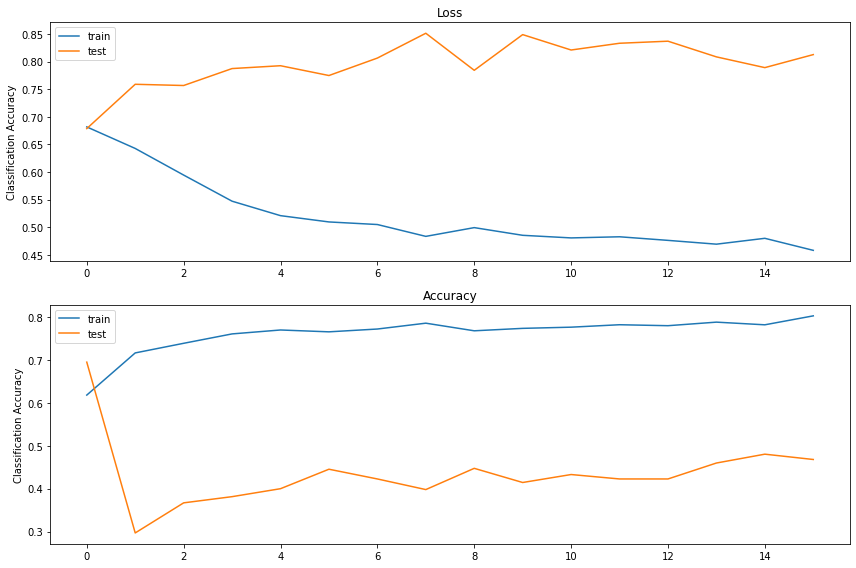

In [ ]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [ ]:
model = BERT_net()
PATH = './Model/state_dict_bert_model_simple.pt'
model.load_state_dict(torch.load(PATH))
__MLP.predict(model, criterion, test_dataloader, test_size)

# BERT Brackets

In [45]:
tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_bert_bracket.values, pheme_y, ext_bert_bracket.values, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 16

train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(0.0397), std: tensor(0.3276)
torch.Size([5802, 1, 768]) torch.Size([485, 1, 768])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [47]:
model_bert = BERT_net()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_bert.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
train_loss = []
train_accuracy = []

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_bert_model_brackets.pt"

In [48]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_bert, num_epochs=100, patience=15, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/99	Train) Acc: 0.6274, Loss: 0.6790
		Validation) Acc: 0.6144 Loss:0.6838
			Saving the best model w/ val loss 0.6838
Epoch 2/99	Train) Acc: 0.7353, Loss: 0.5852
		Validation) Acc: 0.3629 Loss:0.7709
Epoch 4/99	Train) Acc: 0.7709, Loss: 0.5155
		Validation) Acc: 0.4021 Loss:0.7993
Epoch 6/99	Train) Acc: 0.7713, Loss: 0.5031
		Validation) Acc: 0.4351 Loss:0.8061
Epoch 8/99	Train) Acc: 0.7687, Loss: 0.4981
		Validation) Acc: 0.4536 Loss:0.7868
Epoch 10/99	Train) Acc: 0.7758, Loss: 0.4793
		Validation) Acc: 0.4351 Loss:0.8233
Epoch 12/99	Train) Acc: 0.7797, Loss: 0.4742
		Validation) Acc: 0.4227 Loss:0.8405
Epoch 14/99	Train) Acc: 0.7830, Loss: 0.4789
		Validation) Acc: 0.4845 Loss:0.7910
Finishing the Model: Val Loss is not decreasing...
[0.8232505917549133, 0.8338113677255886, 0.8405192492548952, 0.8044906915463124, 0.79097367162557]


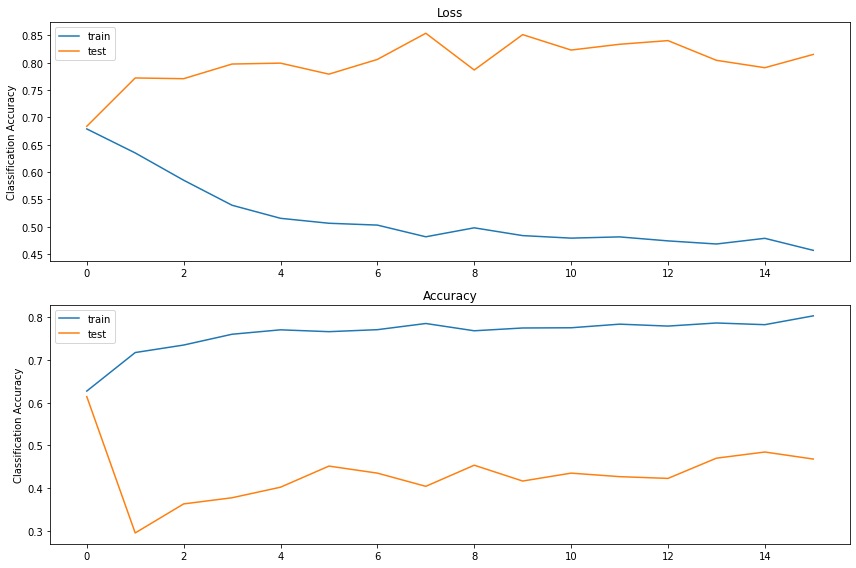

Min of Training Loss: 0.456921
Max of Training Accuracy: 0.803688
Mean of Training Loss: 0.516675
Mean of Training Accuracy: 0.762054
------------
Max of Testing Accuracy: 0.614433
Min of Testing Loss: 0.683816
Mean of Testing Loss: 0.800604
Mean of Testing Accuracy: 0.432474
------------


In [49]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [50]:
model = BERT_net()
PATH = './Model/state_dict_bert_model_brackets.pt'
model.load_state_dict(torch.load(PATH))
__MLP.predict(model, criterion, test_dataloader, test_size)

accuracy_score:	0.6144
Precision Score:	0.8669
Recall Score:	0.5827
f1_score:	0.5671
Test_loss:	0.6838


# BERT Simple + TKNZER

In [12]:
tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_bert_twttknr.values, pheme_y, ext_bert_twttknr.values, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 16

train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(0.0395), std: tensor(0.3292)
torch.Size([5802, 1, 768]) torch.Size([485, 1, 768])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [13]:
model_bert = BERT_net()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_bert.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
train_loss = []
train_accuracy = []

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_bert_model_twttknzr.pt"

In [14]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_bert, num_epochs=100, patience=15, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/99	Train) Acc: 0.6282, Loss: 0.6840
		Validation) Acc: 0.7505 Loss:0.6742
			Saving the best model w/ val loss 0.6742
Epoch 2/99	Train) Acc: 0.7603, Loss: 0.5860
		Validation) Acc: 0.3732 Loss:0.7573
Epoch 4/99	Train) Acc: 0.7827, Loss: 0.5090
		Validation) Acc: 0.3773 Loss:0.8425
Epoch 6/99	Train) Acc: 0.7847, Loss: 0.4906
		Validation) Acc: 0.3856 Loss:0.8756
Epoch 8/99	Train) Acc: 0.7846, Loss: 0.4801
		Validation) Acc: 0.4412 Loss:0.8530
Epoch 10/99	Train) Acc: 0.7902, Loss: 0.4620
		Validation) Acc: 0.4433 Loss:0.8678
Epoch 12/99	Train) Acc: 0.7952, Loss: 0.4554
		Validation) Acc: 0.4165 Loss:0.9231
Epoch 14/99	Train) Acc: 0.7889, Loss: 0.4642
		Validation) Acc: 0.4722 Loss:0.8503
Finishing the Model: Val Loss is not decreasing...
[0.8678096865255808, 0.9218023903591117, 0.9230703465717355, 0.8740398445080236, 0.8502561735123703]


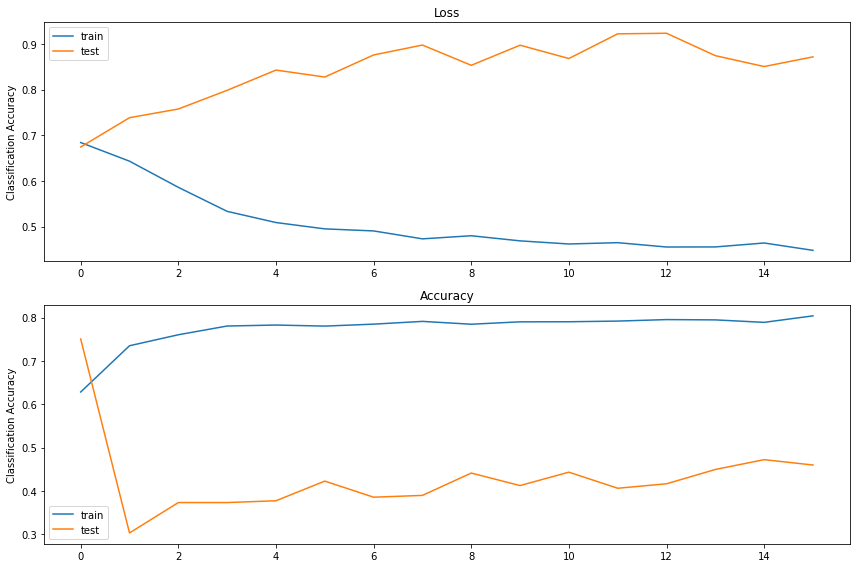

Min of Training Loss: 0.448118
Max of Training Accuracy: 0.803861
Mean of Training Loss: 0.507104
Mean of Training Accuracy: 0.773860
------------
Max of Testing Accuracy: 0.750515
Min of Testing Loss: 0.674221
Mean of Testing Loss: 0.841814
Mean of Testing Accuracy: 0.429768
------------


In [15]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [16]:
model = BERT_net()
PATH = './Model/state_dict_bert_model_twttknzr.pt'
model.load_state_dict(torch.load(PATH))
__MLP.predict(model, criterion, test_dataloader, test_size)

accuracy_score:		0.7505
Precision Score:	0.8069
Recall Score:		0.8835
f1_score:		0.7275
Test_loss:		0.6742


# BERT Lemma

In [10]:
tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_bert_lemma.values, pheme_y, ext_bert_lemma.values, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 16

train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(0.0397), std: tensor(0.3299)
torch.Size([5802, 1, 768]) torch.Size([485, 1, 768])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [11]:
model_bert = BERT_net()

epochs = 100
total_steps = len(train_dataloader) * epochs

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_bert.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
train_loss = []
train_accuracy = []

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_bert_model_lemma.pt"

In [12]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_bert, num_epochs=100, patience=15, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/99	Train) Acc: 0.6182, Loss: 0.6831
		Validation) Acc: 0.7134 Loss:0.6754
			Saving the best model w/ val loss 0.6754
Epoch 2/99	Train) Acc: 0.7289, Loss: 0.5978
		Validation) Acc: 0.3464 Loss:0.7629
Epoch 4/99	Train) Acc: 0.7613, Loss: 0.5318
		Validation) Acc: 0.3938 Loss:0.7973
Epoch 6/99	Train) Acc: 0.7623, Loss: 0.5149
		Validation) Acc: 0.3856 Loss:0.8308
Epoch 8/99	Train) Acc: 0.7623, Loss: 0.5112
		Validation) Acc: 0.4351 Loss:0.7982
Epoch 10/99	Train) Acc: 0.7735, Loss: 0.4911
		Validation) Acc: 0.3959 Loss:0.8418
Epoch 12/99	Train) Acc: 0.7773, Loss: 0.4877
		Validation) Acc: 0.3794 Loss:0.8678
Epoch 14/99	Train) Acc: 0.7751, Loss: 0.4903
		Validation) Acc: 0.4433 Loss:0.8060
Finishing the Model: Val Loss is not decreasing...
[0.8418098163358944, 0.8499053689007906, 0.8678237796444254, 0.8169029697929461, 0.8059781419862176]


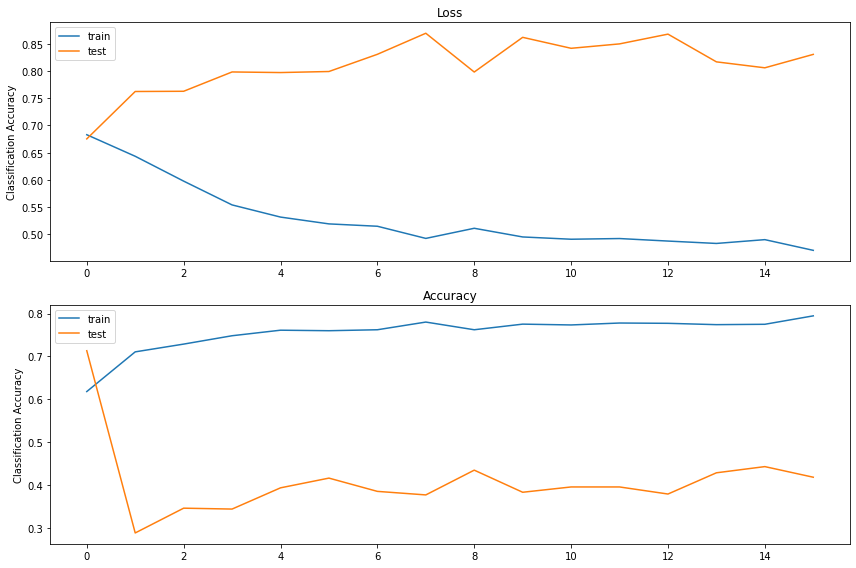

Min of Training Loss: 0.470676
Max of Training Accuracy: 0.794726
Mean of Training Loss: 0.528694
Mean of Training Accuracy: 0.755052
------------
Max of Testing Accuracy: 0.713402
Min of Testing Loss: 0.675404
Mean of Testing Loss: 0.810560
Mean of Testing Accuracy: 0.409149
------------


In [ ]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [ ]:
model = BERT_net()
PATH = './Model/state_dict_bert_model_lemma.pt'
model.load_state_dict(torch.load(PATH))
__MLP.predict(model, criterion, test_dataloader, test_size)

accuracy_score:		0.7134
Precision Score:	0.8363
Recall Score:		0.7751
f1_score:		0.6732
Test_loss:		0.6754


# BERT TKNZR + LEMMA

In [24]:
tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_bert_twttknr_lemma.values, pheme_y, ext_bert_twttknr_lemma.values, ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 16

train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

data = next(iter(train_dataloader))
print("mean: %s, std: %s" %(data[0].mean(), data[0].std()))

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))

print(tensor_x1.size(),tensor_x2.size())
print(tensor_y1.size(),tensor_y2.size())
print("Train Size",train_size,"Test Size",test_size)

mean: tensor(0.0399), std: tensor(0.3304)
torch.Size([5802, 1, 768]) torch.Size([485, 1, 768])
torch.Size([5802, 1]) torch.Size([485, 1])
Train Size 5802 Test Size 485


In [25]:
model_bert = BERT_net()

epochs = 100
total_steps = len(train_dataloader) * epochs

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_bert.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
train_loss = []
train_accuracy = []

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_bert_model_twttknr_lemma.pt"

In [26]:
train_acc, train_loss, val_acc, val_loss_list = __MLP.train_sequential(model=model_bert, num_epochs=100, patience=15, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader,train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)


Epoch 0/99	Train) Acc: 0.6381, Loss: 0.6756
		Validation) Acc: 0.5526 Loss:0.6882
			Saving the best model w/ val loss 0.6882
Epoch 2/99	Train) Acc: 0.7513, Loss: 0.5590
		Validation) Acc: 0.3196 Loss:0.8334
Epoch 4/99	Train) Acc: 0.7740, Loss: 0.5028
		Validation) Acc: 0.3505 Loss:0.8997
Epoch 6/99	Train) Acc: 0.7787, Loss: 0.4892
		Validation) Acc: 0.3670 Loss:0.9220
Epoch 8/99	Train) Acc: 0.7787, Loss: 0.4827
		Validation) Acc: 0.4309 Loss:0.8738
Epoch 10/99	Train) Acc: 0.7832, Loss: 0.4652
		Validation) Acc: 0.4186 Loss:0.9102
Epoch 12/99	Train) Acc: 0.7894, Loss: 0.4606
		Validation) Acc: 0.3876 Loss:0.9650
Epoch 14/99	Train) Acc: 0.7865, Loss: 0.4673
		Validation) Acc: 0.4330 Loss:0.8871
Finishing the Model: Val Loss is not decreasing...
[0.9102369592361843, 0.9487853286192589, 0.9650384188927326, 0.9141212186862513, 0.8871244129446364]


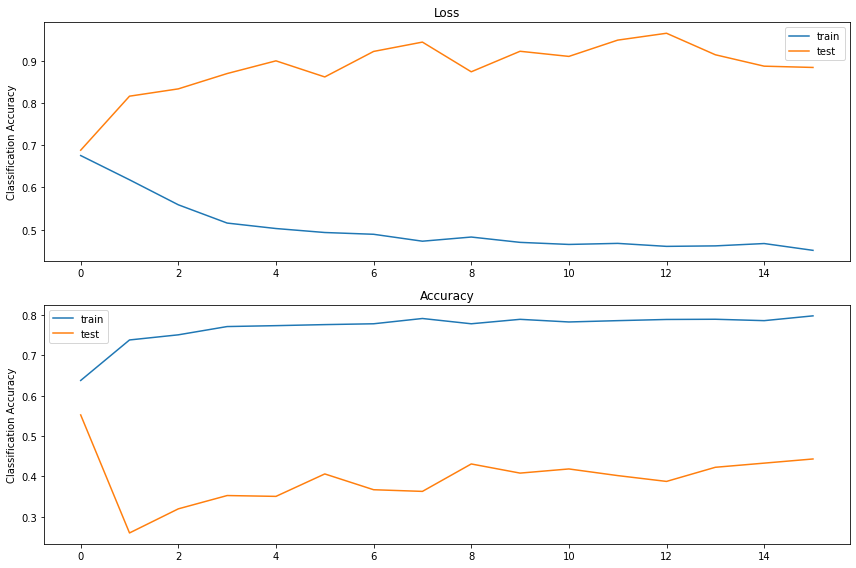

Min of Training Loss: 0.451190
Max of Training Accuracy: 0.798345
Mean of Training Loss: 0.503327
Mean of Training Accuracy: 0.770187
------------
Max of Testing Accuracy: 0.552577
Min of Testing Loss: 0.688216
Mean of Testing Loss: 0.883779
Mean of Testing Accuracy: 0.394845
------------


In [27]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)

In [29]:
model = BERT_net()
PATH = './Model/state_dict_bert_model_twttknr_lemma.pt'
model.load_state_dict(torch.load(PATH))
__MLP.predict(model, criterion, test_dataloader, test_size)

accuracy_score:		0.5526
Precision Score:	0.8725
Recall Score:		0.4824
f1_score:		0.4987
Test_loss:		0.6882


---

## Sparse

In [34]:
#pheme_sparse -> pheme_scaled -> tensor
scaler = StandardScaler()
pheme_scaled = pd.DataFrame(scaler.fit_transform(pheme_sparse))
ext_scaled = pd.DataFrame(scaler.transform(ext_sparse))

tensor_x1, tensor_y1, tensor_x2, tensor_y2 = __MLP.convert_df_to_unsqueezed_tensor(pheme_scaled,pheme_y,ext_scaled,ext_y)
train_dataset = TensorDataset(tensor_x1,tensor_y1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)

batch_size = 16
train_sampler, test_sampler = __MLP.getSamplers(pheme_y, tensor_x2)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

train_size, test_size = int(tensor_y1.size(0)), int(tensor_y2.size(0))

print("Training: ",tensor_x1.shape,"/", tensor_x2.shape)
print("Testing2: ",tensor_y1.shape,"/", tensor_y2.shape)
print("Train Size",train_size,"/ Test Size",test_size)
PATH = './Model/BERTweet_raw_to_fine_tune_SimplePrdep.pt'


Training:  torch.Size([5802, 1, 36]) / torch.Size([485, 1, 36])
Testing2:  torch.Size([5802, 1]) / torch.Size([485, 1])
Train Size 5802 / Test Size 485


In [ ]:
# bert_classifier.load_state_dict(torch.load(PATH))
# testing_process(bert_classifier, X_val, y_val)
predict(model, criterion, val_dataloader, val_size)

In [24]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

NameError: name 'bert_predict' is not defined

In [ ]:
PATH = './Model/BERTweet_raw_to_fine_tune_SimplePrdep.pt'
bert_classifier.load_state_dict(torch.load(PATH))
testing_process(bert_classifier, X_val, y_val)

In [ ]:
PATH = './Model/BERTweet_raw_to_fine_tune_SimplePrep.pt'
bert_classifier.load_state_dict(torch.load(PATH))
testing_process(bert_classifier, X_val, y_val)

In [ ]:
def predict(model, criterion, val_dataloader, val_size):
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        for j, val in enumerate(val_dataloader, 0):
            val_x, val_label = val
            val_x, val_label = val_x.float(), val_label.float()
            val_outputs = model(val_x)
            val_preds = val_outputs.squeeze(1) > 0.0

            val_preds_list.append(val_preds)
            val_label_list.append(val_label)
            v_loss = criterion(val_outputs, val_label.unsqueeze(1))
            val_loss += (v_loss.item() * val_x.size(0))
            val_corrects += torch.sum(val_preds == val_label)

    val_preds_list = torch.cat(val_preds_list, 0)
    val_label_list = torch.cat(val_label_list, 0)
    val_corrects = val_corrects/val_size
    val_loss = val_loss/test_size
    val_acc = val_corrects.double() / val_size

    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
        val_corrects/val_size, val_loss/test_size))
    
    print(classification_report(y_test, result))

    return val_acc, val_loss, val_corrects, val_preds_list, val_label_list